In [2]:
!pip install geopandas
import json
from shapely.geometry import Point
import geopandas as gpo
from geopandas import GeoDataFrame
import plotly.express as px

import pandas as po
import numpy as np

import re
import time

import requests
from bs4 import BeautifulSoup

data = po.read_csv("data/Cleaned_airports.csv", index_col=0, parse_dates=True)
data['Airport.Name'] = data['Airport.Name'].str.strip()
data.head()

,Airport.Code,Airport.Location,Airport.Name,Statistics.# of Delays.Carrier,Statistics.# of Delays.Late Aircraft,Statistics.# of Delays.National Aviation System,Statistics.# of Delays.Security,Statistics.# of Delays.Total,Statistics.# of Delays.Weather,Statistics.Carriers.Names,...,Statistics.Minutes Delayed.Carrier,Statistics.Minutes Delayed.Late Aircraft,Statistics.Minutes Delayed.National Aviation System,Statistics.Minutes Delayed.Security,Statistics.Minutes Delayed.Total,Statistics.Minutes Delayed.Weather,Time.Label,Time.Month,Time.Month Name,Time.Year
0,ATL,"Atlanta, GA",Hartsfield-Jackson Atlanta International,1009,1275,3217,17,5846,328,"American Airlines Inc.,JetBlue Airways,Contine...",...,61606,68335,118831,518,268764,19474,2003-06-01,6,June,2003
1,TPA,"Tampa, FL",Tampa International,226,327,524,3,1122,42,"American Airlines Inc.,JetBlue Airways,Contine...",...,11012,18558,19078,112,51364,2604,2003-06-01,6,June,2003
2,SLC,"Salt Lake City, UT",Salt Lake City International,363,290,352,15,1056,36,"American Airlines Inc.,JetBlue Airways,Contine...",...,16227,13883,10512,556,42863,1685,2003-06-01,6,June,2003
3,SFO,"San Francisco, CA",San Francisco International,416,312,1080,14,1881,59,"American Airlines Inc.,Alaska Airlines Inc.,Co...",...,22673,17879,45407,1138,90487,3390,2003-06-01,6,June,2003
4,SEA,"Seattle, WA",Seattle/Tacoma International,448,552,454,28,1518,36,"American Airlines Inc.,Alaska Airlines Inc.,Je...",...,22647,28119,13860,1097,68673,2950,2003-06-01,6,June,2003


# Web scraping

In [53]:

test_url = "https://www.google.com/search?q=latitude+longitude+Tampa+International"


def scrape_latlon(airport : str, div_class : str) -> tuple:
  """
  Send request, parse response, return coordinates
  """
  headers = {
    "User-Agent":
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3538.102 Safari/537.36 Edge/18.19582"
  }
  airport = airport.strip()
  airport = airport.replace(" ","+")

  # Send request
  url = "https://www.google.com/search?q=latitude+longitude+{}".format(airport)
  response = requests.get(url, headers=headers)
  soup = BeautifulSoup(response.content, 'html.parser')

  # parse response
  div_with_info = (soup.find_all("div", {"class": div_class}))[0]
  coords = re.findall("(-?\d+\.\d+)° (\w)", str(div_with_info))

  # return coordinates
  return coords

scrape_latlon(airport = "Tampa International", div_class = 'BNeawe iBp4i AP7Wnd')

[('27.9772', 'N'), ('82.5311', 'W')]

In [56]:
def convert_latlon_to_decimal(coord_pair):
  """
  A coord_pair should look something like: [('33.6407', 'N'), ('84.4277', 'W')]
  Then the corresponding decimal degree lat-lon would be: 33.6407, -84.4277

  Assumes (latitude, longitude) coordinate pair.
  """

  assert len(coord_pair) == 2, "{} is not in the correct format".format(str(coord_pair))
  lat_decimal = float(coord_pair[0][0])
  lat_dir = coord_pair[0][1]

  lon_decimal = float(coord_pair[1][0])
  lon_dir = coord_pair[1][1]

  if lat_dir == 'S':
    lat_decimal *= -1

  if lon_dir == 'W':
    lon_decimal *= -1

  return (lat_decimal, lon_decimal)

convert_latlon_to_decimal(coords)

(33.6407, -84.4277)

In [57]:
import time
airport_and_coords_dict = {name: None for name in data['Airport.Name'].unique()}

for name in data['Airport.Name'].unique():
  coords = scrape_latlon(name, div_class = 'BNeawe iBp4i AP7Wnd')
  coords = convert_latlon_to_decimal(coords)
  airport_and_coords_dict[name] = coords
  print(name, coords)
  time.sleep(10) # to avoid over-requesting and getting banned

airport_and_coords_dict

Hartsfield-Jackson Atlanta International (33.6407, -84.4277)
Tampa International (27.9772, -82.5311)
Salt Lake City International (40.7899, -111.9791)
San Francisco International (37.6213, -122.379)
Seattle/Tacoma International (47.4502, -122.3088)
San Diego International (32.7338, -117.1933)
Phoenix Sky Harbor International (33.4352, -112.0101)
Philadelphia International (39.8729, -75.2437)
Chicago O'Hare International (41.9803, -87.909)
Minneapolis-St Paul International (44.8848, -93.2223)
Miami International (25.7959, -80.2871)
Chicago Midway International (41.7868, -87.7522)
Orlando International (28.4179, -81.3041)
LaGuardia (40.7769, -73.874)
Portland International (45.5152, -122.6784)
McCarran International (36.084, -115.1537)
Los Angeles International (33.9416, -118.4085)
Baltimore/Washington International Thurgood Marshall (39.1774, -76.6684)
Charlotte Douglas International (35.2144, -80.9473)
Ronald Reagan Washington National (38.8512, -77.0402)
Denver International (39.8561,

{'Baltimore/Washington International Thurgood Marshall': (39.1774, -76.6684),
 'Charlotte Douglas International': (35.2144, -80.9473),
 'Chicago Midway International': (41.7868, -87.7522),
 "Chicago O'Hare International": (41.9803, -87.909),
 'Dallas/Fort Worth International': (32.8998, -97.0403),
 'Denver International': (39.8561, -104.6737),
 'Detroit Metro Wayne County': (42.2162, -83.3554),
 'Fort Lauderdale-Hollywood International': (26.0742, -80.1506),
 'George Bush Intercontinental/Houston': (29.9902, -95.3368),
 'Hartsfield-Jackson Atlanta International': (33.6407, -84.4277),
 'John F. Kennedy International': (40.6413, -73.7781),
 'LaGuardia': (40.7769, -73.874),
 'Logan International': (42.3656, -71.0096),
 'Los Angeles International': (33.9416, -118.4085),
 'McCarran International': (36.084, -115.1537),
 'Miami International': (25.7959, -80.2871),
 'Minneapolis-St Paul International': (44.8848, -93.2223),
 'Newark Liberty International': (40.6895, -74.1745),
 'Orlando Interna

# Save data as csv

In [72]:
lat_lon_df = (po.DataFrame(airport_and_coords_dict).T
              .reset_index()
              .rename({'index': 'Airport.Name',0:'Latitude', 1:'Longitude'}, axis=1))
lat_lon_df

,Airport.Name,Latitude,Longitude
0,Hartsfield-Jackson Atlanta International,33.6407,-84.4277
1,Tampa International,27.9772,-82.5311
2,Salt Lake City International,40.7899,-111.9791
3,San Francisco International,37.6213,-122.3790
4,Seattle/Tacoma International,47.4502,-122.3088
5,San Diego International,32.7338,-117.1933
6,Phoenix Sky Harbor International,33.4352,-112.0101
7,Philadelphia International,39.8729,-75.2437
8,Chicago O'Hare International,41.9803,-87.9090
9,Minneapolis-St Paul International,44.8848,-93.2223


In [66]:
lat_lon_df.to_csv("outputs/airports_lat_lon.csv")

# Data visualization

In [91]:
airports_delay_chance_dict = None

with open("outputs/airport-delay_chance.json", 'r') as f:
  airports_delay_chance_dict = json.load(f)

airports_delay_chance_df = (po.DataFrame(po.Series(airports_delay_chance_dict))
                              .reset_index()
                              .rename({'index': 'Airport.Name', 0:'Chance of Delay'}, axis=1)
                            )
airports_delay_chance_df['Airport.Name'] = airports_delay_chance_df['Airport.Name'].str.strip()
airports_delay_chance_df

,Airport.Name,Chance of Delay
0,Salt Lake City International,0.150310
1,Phoenix Sky Harbor International,0.163098
2,Chicago Midway International,0.173389
3,Denver International,0.175961
4,Dallas/Fort Worth International,0.177066
5,Baltimore/Washington International Thurgood Ma...,0.179197
6,George Bush Intercontinental/Houston,0.179234
7,Charlotte Douglas International,0.183684
8,Detroit Metro Wayne County,0.185233
9,Portland International,0.185555


In [153]:
merged_latlon_chance_df = (lat_lon_df.merge(airports_delay_chance_df, left_on = 'Airport.Name', right_on = 'Airport.Name')
                                    .sort_values('Chance of Delay')
                                    .reset_index(drop=True)
                            )
merged_latlon_chance_df['Chance of Delay'] *= 100

In [157]:
# Converting lat, lon data to Point objects and GeoDataFrames
geometry = [Point(xy) for xy in zip(merged_latlon_chance_df['Longitude'], merged_latlon_chance_df['Latitude'])]
gdf = GeoDataFrame(merged_latlon_chance_df, geometry=geometry)

# Plotting airport points over world map
fig = px.scatter_geo(gdf, lon=gdf.geometry.x, lat=gdf.geometry.y, color='Chance of Delay', hover_data=['Airport.Name'])
fig.update_traces(marker=dict(size=12))

In [159]:
gdf.to_csv("outputs/geopandas_latlon.csv")

In [155]:
# US Map data
#world = gpo.read_file(gpo.datasets.get_path('naturalearth_lowres'))
#usa = world[world['name'] == 'United States of America']

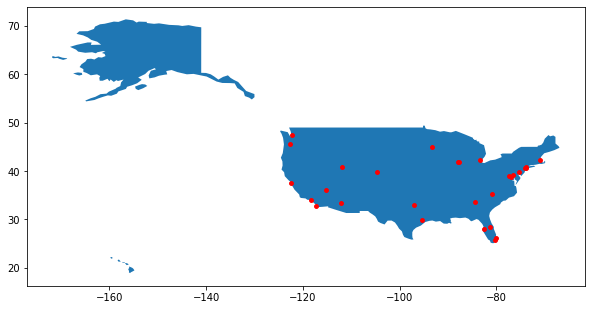

In [126]:

#fig = px.scatter(merged_latlon_chance_df, x='Longitude', y='Latitude', size='Chance of Delay',hover_data=['Airport.Name'])
#gdf.plot(ax=usa.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [ ]:
# Other Ideas:
# given a starting point, find optimal routes to all other airports